<a href="https://colab.research.google.com/github/rabernat/sst_superresolution/blob/master/load_and_plot_SST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Analysis Ready SST Data

The data is stored in [zarr format](https://zarr.readthedocs.io) in Google Cloud Storage.

We read it with the [xarray](http://xarray.pydata.org/en/latest/) library.

We need to install some extra packages on Google Colab for this to work.

In [0]:
! pip install xarray==0.12.3 zarr gcsfs intake intake-xarray

Create Xarray object pointing to the data.

In [0]:
import fsspec
import xarray as xr 

# just get the first 10 timesteps for now
uris = [f'gcs://pangeo-ocean-ml/LLC4320/SST.{tstep:010d}.zarr'
        for tstep in range(0, 4088+1, 73)][:10]

dsets = [xr.open_zarr(fsspec.get_mapper(uri), consolidated=True)
         for uri in uris]

ds = xr.combine_nested(dsets, 'timestep')
ds

<xarray.Dataset>
Dimensions:  (region: 321, timestep: 10, x: 512, y: 512)
Coordinates:
  * x        (x) float64 -2.555e+05 -2.545e+05 ... 2.545e+05 2.555e+05
    y        (x) float64 2.555e+05 2.545e+05 2.535e+05 ... -2.545e+05 -2.555e+05
Dimensions without coordinates: region, timestep
Data variables:
    SST      (timestep, region, y, x) float64 dask.array<shape=(10, 321, 512, 512), chunksize=(1, 1, 512, 512)>

The data are organized into 321 distinct regions, all of the same size. There are 53 different timesteps, but in this example, we just loaded 10.


This object is "lazy". The data aren't actually loaded until we try to plot or explicitly call `.load()` on them.

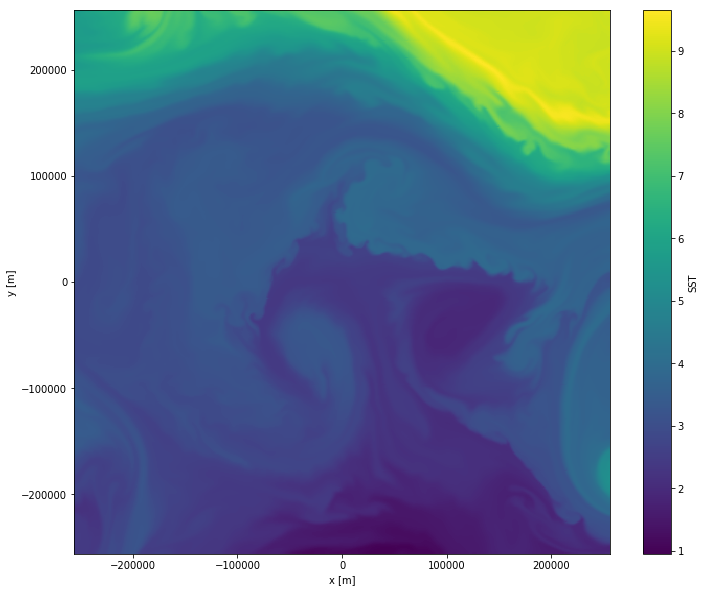

In [0]:
ds.SST[0, 10].plot(figsize=(12, 10))

### Create Coarse Resolution Version

Xarray can take care of this for us. Here we coarsen by a factor of 16

In [0]:
sst_coarse = ds.SST.coarsen(x=16, y=16).mean()
sst_coarse

<xarray.DataArray (timestep: 10, region: 321, y: 32, x: 32)>
dask.array<shape=(10, 321, 32, 32), dtype=float64, chunksize=(1, 1, 32, 32)>
Coordinates:
  * x        (x) float64 -2.48e+05 -2.32e+05 -2.16e+05 ... 2.32e+05 2.48e+05
    y        (x) float64 2.48e+05 2.32e+05 2.16e+05 ... -2.32e+05 -2.48e+05
Dimensions without coordinates: timestep, region

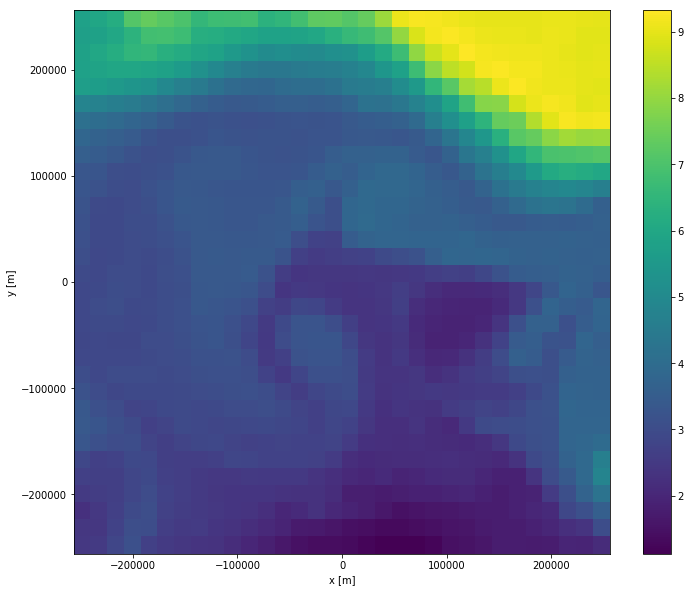

In [0]:
sst_coarse[0, 10].plot(figsize=(12, 10))

### Remove data with NaNs

Because of how they were produced, some of the data have NaNs.

Fortunately this mask is the same for every timestep.

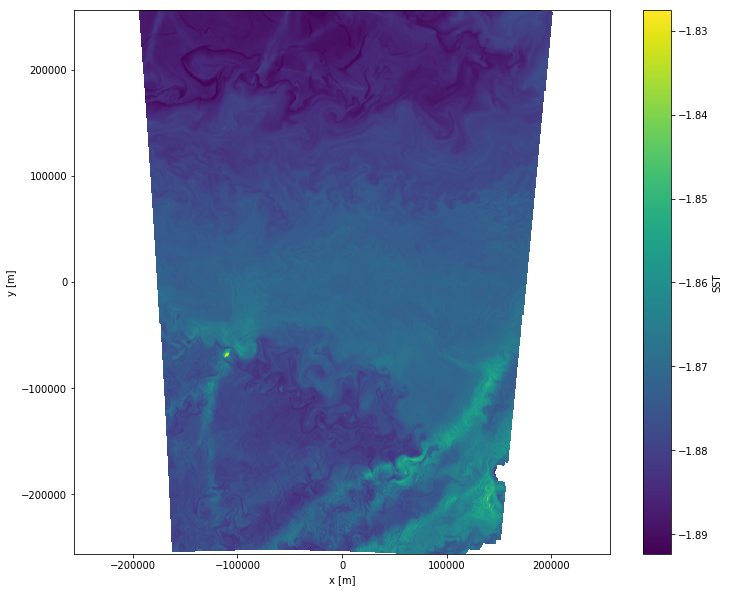

In [0]:
ds.SST[0, 0].plot(figsize=(12, 10))

This next step is 

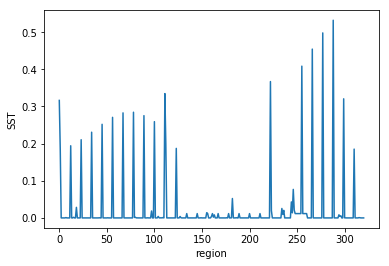

In [0]:
num_nans = ds.SST[0].isnull().sum(dim=['x', 'y']).load()
(num_nans / (ds.dims['x'] * ds.dims['y'])).plot()

Now we remove the NaN regions. The object below should have only good data.

In [0]:
sst_valid = ds.SST.where(num_nans == 0, drop=True)
sst_valid

<xarray.DataArray 'SST' (timestep: 10, region: 236, y: 512, x: 512)>
dask.array<shape=(10, 236, 512, 512), dtype=float64, chunksize=(1, 1, 512, 512)>
Coordinates:
  * x        (x) float64 -2.555e+05 -2.545e+05 ... 2.545e+05 2.555e+05
    y        (x) float64 2.555e+05 2.545e+05 2.535e+05 ... -2.545e+05 -2.555e+05
Dimensions without coordinates: timestep, region